In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple, Any, NamedTuple, Callable

from Ecosystem.types import Ecosystem
from Ecosystem.temp import setup
from Ecosystem.utils import mult_by_layer, default_ecosystem, set_random
from Ecosystem.operations import calc_energy, get_neighbors
# from Ecosystem.simulators import grow

np.set_printoptions(suppress=True)

In [2]:
def grow(
  system: Ecosystem, 
  plants: pd.DataFrame
) -> Ecosystem:
  
  res, spc, ene = system.resource, system.species, system.energy
  rel = plants.filter(regex='p')
  
  n_spc = np.zeros_like(spc)
  n_res = np.zeros_like(res)
  
  N = spc
  K_ene = res + mult_by_layer(N, plants.e)
  K_ene[K_ene.round(4) == 0] = 1e-4
  K_num = mult_by_layer(K_ene, 1/plants.e)

  # Logistic
  interaction = np.array([mult_by_layer(N, rel.iloc[i]).sum(axis=0) for i in range(len(spc))])
  occ = np.ones_like(spc)
  occ[spc==0] = 0
  interaction *= occ
  logistic = mult_by_layer(N * (1 - (N - interaction) / K_num), plants.r)
  n_spc = N + logistic
  n_spc[n_spc<1e-4] = 0
  n_res = ene - calc_energy(n_spc, plants)
  
  return Ecosystem(n_res, n_spc, ene)

def seed(
  system: Ecosystem, 
  plants: pd.DataFrame,
  distance: int = 1,
) -> Ecosystem:
  res, spc, ene = system.resource, system.species, system.energy
  z, y, x = spc.shape
  seeds = get_neighbors(spc, distance)
  
  n_spc = spc.copy() + mult_by_layer(seeds, plants.g)
  n_res = ene - calc_energy(n_spc, plants)
  return Ecosystem(n_res, n_spc, ene)

def harvest(
  system: Ecosystem,
  plants: pd.DataFrame,
) -> Ecosystem:
  res, spc, ene = system.resource, system.species, system.energy
  n_spc = spc.copy()
  n_res = np.zeros_like(res)
  
  idx = res < 0
  coef = np.ones_like(res)
  coef[idx] = (ene / (-res[idx] + ene))
  
  rate = spc.sum(1).sum(1)
  rate /= rate.sum()
  
  human = (1 - 0.3 * np.random.rand())
  n_spc *= human * coef
  n_spc[np.random.rand(len(spc)) < rate, :, :] *= human
  
  n_res = ene - calc_energy(n_spc, plants)
  return Ecosystem(n_res, n_spc, ene)

# Case 1: Plants located on the edges

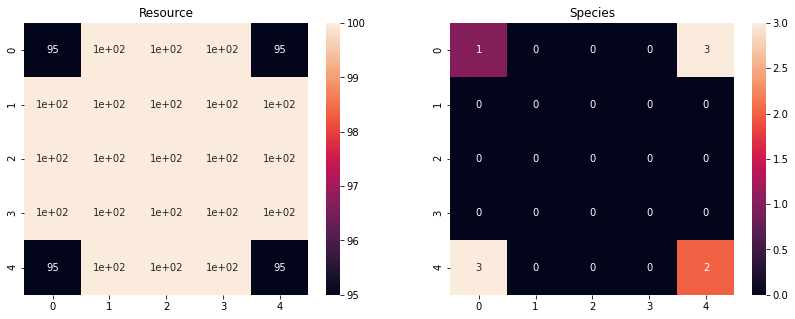

In [3]:
system, plants = setup("./Ecosystem/plants.csv")
res, spc, ene = system.resource, system.species, system.energy

system = Ecosystem(90+res, spc, 100)
system.heatmap()

<AxesSubplot:>

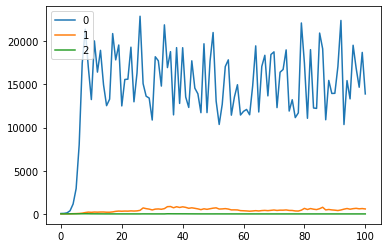

In [4]:
buffer = [system]

for i in range(100):
  system = grow(system, plants)
  system = seed(system, plants)  
  system = harvest(system, plants)
  buffer.append(system)

result = pd.DataFrame([[b.species.sum(1).sum(1)[i] for b in buffer] for i in range(3)]).T
result.plot()

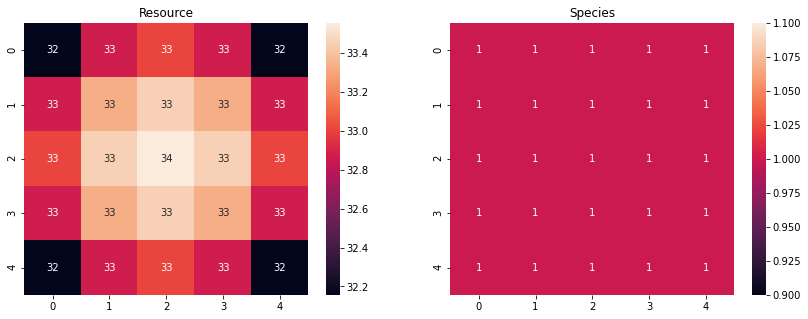

In [5]:
buffer[100].heatmap()

# Case2: plants located on the same position

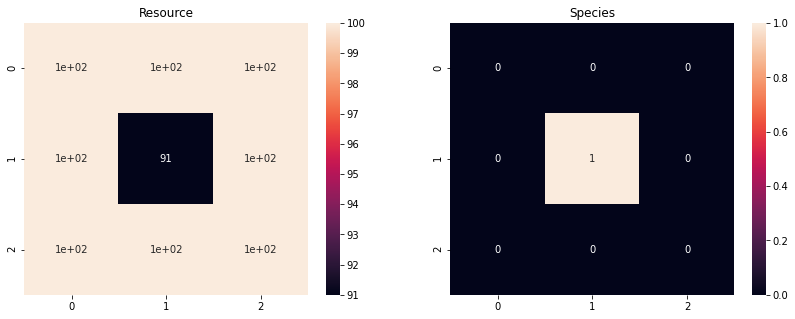

In [6]:
sys = default_ecosystem((3,3), 3, 100)
p = pd.read_csv('./Ecosystem/plants.csv')
r, s, e = sys.resource, sys.species, sys.energy

s[0][1,1] = 30
s[1][1,1] = 6
s[2][1,1] = 3

r = e - calc_energy(s, p)

sys = Ecosystem(r, s, e)
sys.heatmap()

<AxesSubplot:>

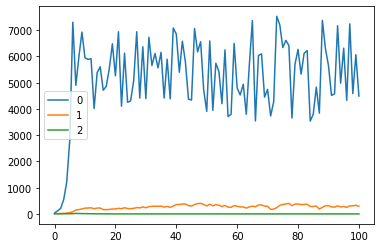

In [7]:
b = [sys]
for i in range(100):
  sys = grow(sys, p)
  sys = seed(sys, p)
  sys = harvest(sys, p)
  b.append(sys)

result = pd.DataFrame([[_b.species.sum(1).sum(1)[i] for _b in b] for i in range(3)]).T
result.plot()

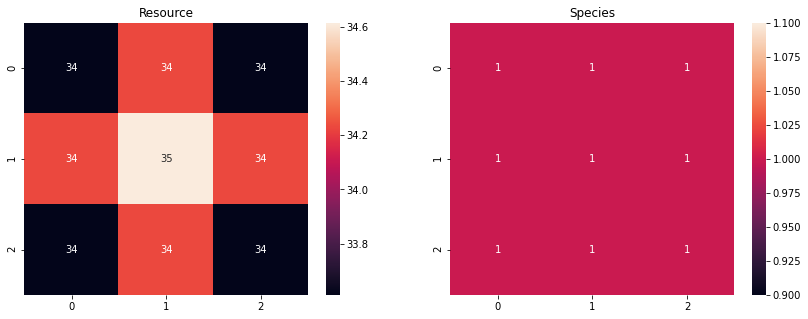

In [8]:
b[100].heatmap()

# 100 spec with random

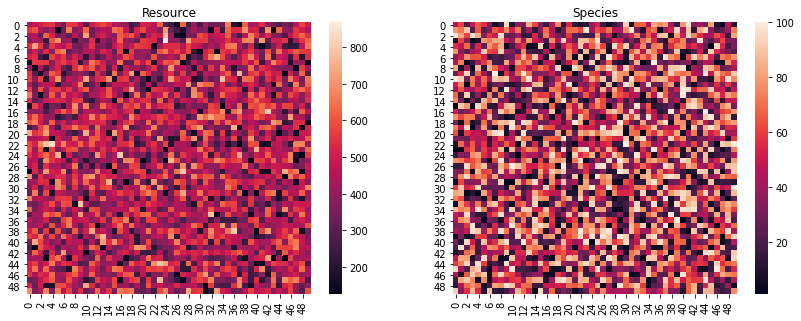

In [9]:
p = pd.read_csv('./Ecosystem/100spec.csv', index_col=0)
system = default_ecosystem((50, 50), 100, 1000)
res, spc, ene = system.resource, system.species, system.energy

spc = set_random(spc, 500)
res = ene - calc_energy(spc, p)

system = harvest(Ecosystem(res, spc, ene), p)

system.heatmap(False)

<AxesSubplot:>

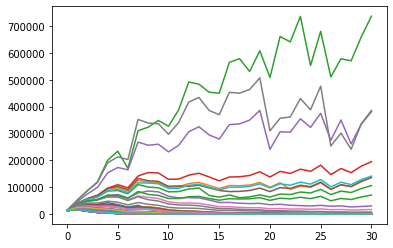

In [10]:
b = [system]
for i in range(30):
  system = grow(system, p)
  system = seed(system, p)
  system = harvest(system, p)
  b.append(system)

result = pd.DataFrame(
  [[_b.species.sum(1).sum(1)[i] for _b in b] for i in range(len(system.species))],
  index = [f"p_{i}" for i in range(len(system.species))]
).T

result.plot(legend=None)

<AxesSubplot:>

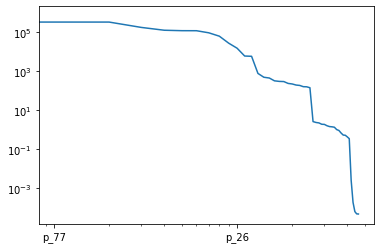

In [11]:
temp = result.iloc[29]
temp[temp>0].sort_values(ascending=False).plot(logx=True, logy=True)

In [12]:
temp.sort_values(ascending=False).head(30).index

Index(['p_42', 'p_77', 'p_74', 'p_23', 'p_59', 'p_25', 'p_21', 'p_12', 'p_82',
       'p_24', 'p_26', 'p_27', 'p_97', 'p_60', 'p_28', 'p_11', 'p_75', 'p_6',
       'p_66', 'p_33', 'p_76', 'p_34', 'p_54', 'p_69', 'p_67', 'p_3', 'p_15',
       'p_64', 'p_61', 'p_37'],
      dtype='object')

<AxesSubplot:>

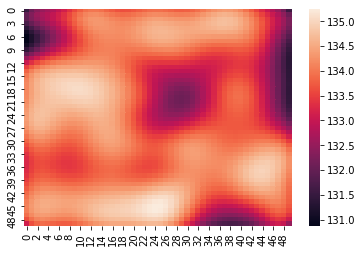

In [13]:
sns.heatmap(b[29].species[74])

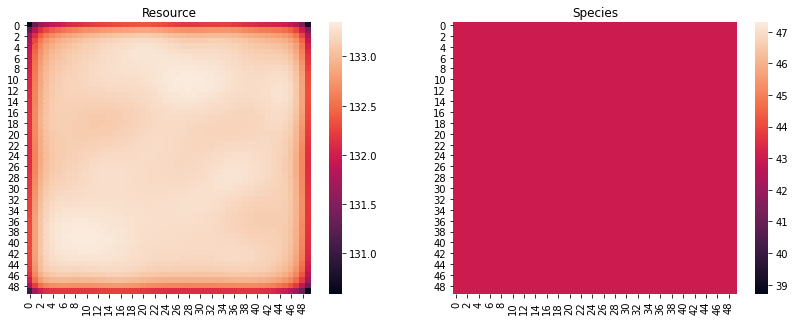

In [14]:
b[29].heatmap(False)